In [1]:
#configure a temp run engine environment

from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

0

In [2]:
import databroker
list(databroker.catalog)

import databroker
db = databroker.catalog["sissy2"]

In [3]:
#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
#from databroker.v2 import temp
#db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)

1

In [5]:
from bluesky.plans import count
from bluesky.plans import rel_scan
from bluesky.plan_stubs import *
from bluesky.plan_stubs import mv
from ophyd.sim import det4, motor1, motor2
from IPython.display import clear_output
import bluesky.preprocessors as bpp

import databroker.core
handler_registry = databroker.core.discover_handlers()
# make sure that the python package area-detector-handlers is installed!

from bessyii_devices.camera import *

camera_tiff = DetectorTiff(name="camera_tiff", prefix="13URL1:")
camera_stream = DetectorStream(name="camera_stream", prefix="13URL1:")

camera_stream_signal = DetectorStreamSignals(prefix="13URL1:", name="image")
camera_tiff_signal = DetectorTiffSignals(prefix="13URL1:", name="image")

# definition of the motors
move_sigma_x = MySimCamSigmaX('13URL1:', name='move_sigma_x')
move_sigma_y = MySimCamSigmaY('13URL1:', name='move_sigma_y')

#camera_stream_test = Detector_stream_Signals(name="camera_stream_test") 
#pil1m_roi2 = EpicsSignal('SISSY1EX:Simdetector1:Stats1:Total_RBV', name= 'test')    
#orienbtation = EpicsSignal('SISSY1EX:Simdetector1:Stats1:Orientation_RBV', name= 'test')    

#set_detector_tiff(camera_tiff)
#set_detector_stream(camera_stream)
#set_detector_stream_Signals(camera_stream_signal)
set_detector_tiff_Signals(camera_tiff_signal)

from bessyii_devices.end_stations import OAESE
oaese = OAESE('SISSY2EX:', name='oaese')
oaese.wait_for_connection()

In [7]:
# acquire an image. a single image (num=1) change number 
RE(count([camera_tiff_signal], num=1)) # RE(count([camera], num=2))

scaling_factor = 0.785

FWHM_horiz_um = camera_stream_signal.FWHM_x.get() * scaling_factor
FWHM_vert_um = camera_stream_signal.FWHM_y.get() * scaling_factor


print('###################################################################')
print(f'Size of the spot in micrometer:\nFWHM_horiz = {round(FWHM_horiz_um, 2)}\nFWHM_vert = {round(FWHM_vert_um, 2)}')
print('###################################################################')





Transient Scan ID: 2     Time: 2021-08-30 18:04:06
Persistent Unique Scan ID: 'ea27ac3b-3b2f-49bc-a0df-456fd4950b60'
New stream: 'primary'
+-----------+------------+------------+------------+--------------+--------------+---------------------+-------------------+--------------+--------------+
|   seq_num |       time | image_cm_x | image_cm_y | image_cm_c_x | image_cm_c_y | image_Max_Intensity | image_orientation | image_FWHM_x | image_FWHM_y |
+-----------+------------+------------+------------+--------------+--------------+---------------------+-------------------+--------------+--------------+
|         1 | 18:04:06.5 |        802 |        148 |        641.2 |        358.3 |                 155 |             0.189 |        872.0 |        490.8 |
+-----------+------------+------------+------------+--------------+--------------+---------------------+-------------------+--------------+--------------+
generator count ['ea27ac3b'] (scan num: 2)



######################################

In [ ]:
# Note: The poor_man_focus_chamber_def_stream.py is not added to the folder

print('######################## Output Script Simone #####################')
#######################
# call Simone's script 
#from backup.poor_man_focus_chamber_def_stream import calc_FWHM
from poor_man_focus_chamber_def_stream import calc_FWHM

# reshape the current acquired image. It has the dimension: (y = 720) x (x = 1200) pixel
current_array_image = camera_stream_signal.stream_image_array.get()
reashped_current_array_image = np.reshape(current_array_image, (720, 1280))

# angle between the ong direction of the spot with respect to the horizon
orientation_angle = camera_stream_signal.orientation.get()
threshold_for_background = 0.2
# uncomment, when you don't like to run Simone's script!
calc_FWHM(reashped_current_array_image, 'steam_image', orientation_angle, pixel_to_mm_factor, threshold_for_background)

In [25]:
oaese.x.user_readback.get()

-4500.0

In [26]:
oaese.y.user_readback.get()

-4500.0

In [27]:
oaese.z.user_readback.get()

-1500.0101999999997



Transient Scan ID: 5     Time: 2021-08-27 17:09:41
Persistent Unique Scan ID: 'c2aabd97-1f03-4c5d-963b-e62e2ab0699d'
New stream: 'primary'
+-----------+------------+------------+-----------------+-------------------+--------------------+--------------------+--------------------+
|   seq_num |       time |    oaese_x | image_MaxCounts | image_orientation | image_spot_sigma_x | image_FWHM_sigma_x | image_FWHM_sigma_y |
+-----------+------------+------------+-----------------+-------------------+--------------------+--------------------+--------------------+
|         1 | 17:09:43.3 | -4200.00000 |             191 |             1.258 |              143.0 |              336.7 |              117.1 |
|         2 | 17:09:45.0 | -4244.37500 |             186 |             1.209 |              142.3 |              335.0 |              118.4 |
|         3 | 17:09:46.7 | -4288.90625 |             188 |             1.144 |              141.8 |              333.9 |              119.1 |
|         

('c2aabd97-1f03-4c5d-963b-e62e2ab0699d',)

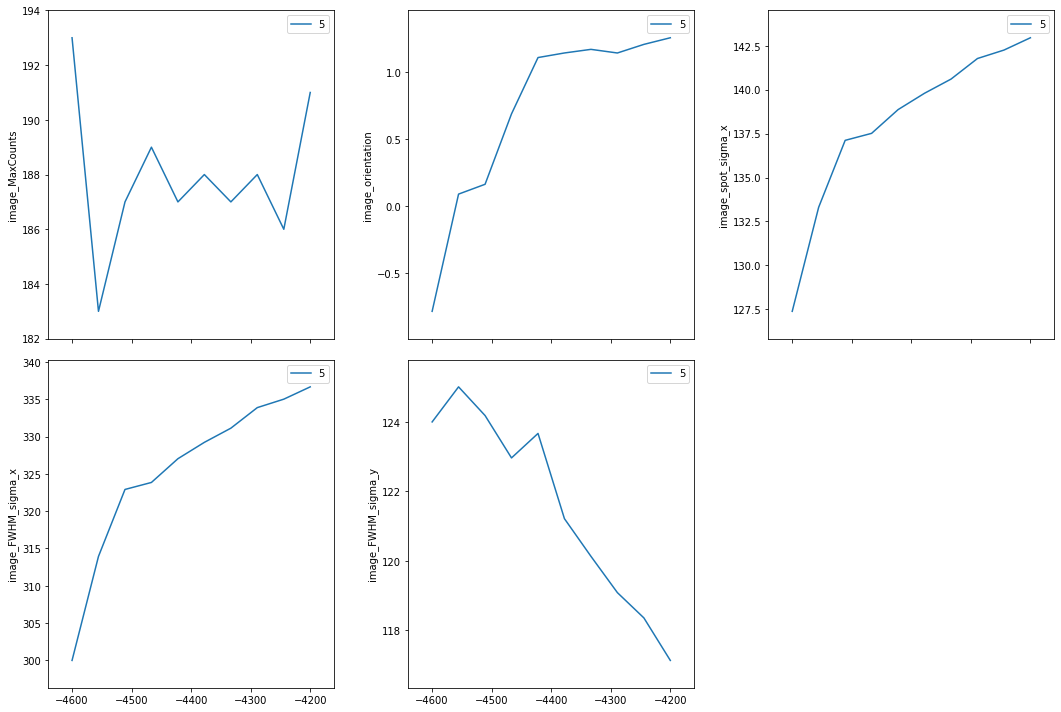

In [30]:
from EMIL_Bluesky_Notebooks.bessyii.plans.scan import scan

# camera, motor, start, stop, stepsize

RE(scan([camera_tiff_signal], oaese.x, -4200 , -4600, 10))  

#RE(scan([camera_stream_signal], oaese.y, -4300 , -4600, 10))
#RE(scan([camera_stream_signal], oaese.z, -4300 , -4600, 10))
#RE(scan([camera_stream_signal], oaese.x, -4300 , -4600, oaese.y, -4300 , -4600, oaese.z, -4300 , -4600, 10))